[Generative Adversarial Nets (2014) Goodfellow et al](https://arxiv.org/pdf/1406.2661.pdf)


Generator (creates fake images from noise)

```G(z) -> x```

Discriminator (classifies real | fake images)

```D(x) -> p(x)```

x = real | fake images 

z = noise

In [1]:
from PIL import Image

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
Z_SIZE = 100
MINIBATCH_SIZE = 64
DEVICE = "cuda"

In [3]:
data = torchvision.datasets.MNIST(
    root=".",
    download=True,
    transform=transforms.ToTensor()
)
dataloader = DataLoader(data, batch_size=MINIBATCH_SIZE, drop_last=True)

In [4]:
def create_image(tensor):
    grid = torchvision.utils.make_grid(
        tensor,
        nrow=8, padding=2, pad_value=0,
        normalize=True, range=None, scale_each=False
    )
    return grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()


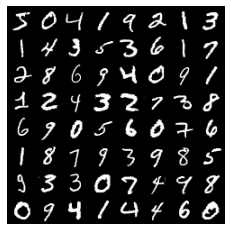

In [5]:
x, _ = next(iter(dataloader))
plt.imshow(create_image(x))
_ = plt.axis("off")

In [6]:
IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH = data[0][0].shape
X_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_CHANNELS

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(X_SIZE, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(Z_SIZE, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, X_SIZE)
        
    def forward(self, z):
        x = torch.flatten(z, 1)
        
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x.view(-1, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)

In [9]:
def sample_z(batch_size):
    return torch.normal(0.0, 1.0, (batch_size, Z_SIZE)).to(DEVICE)

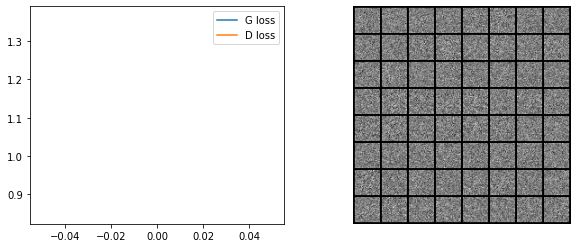

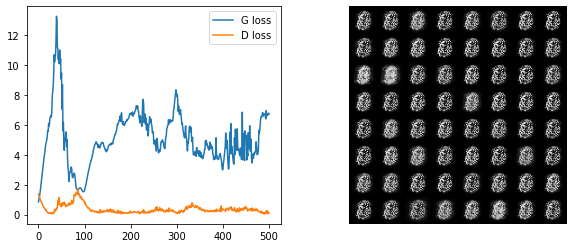

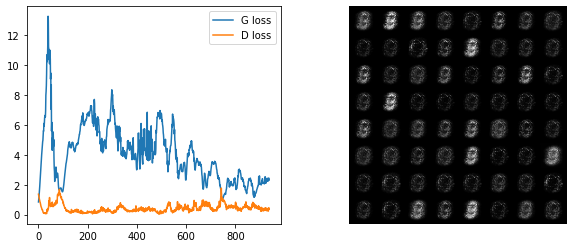

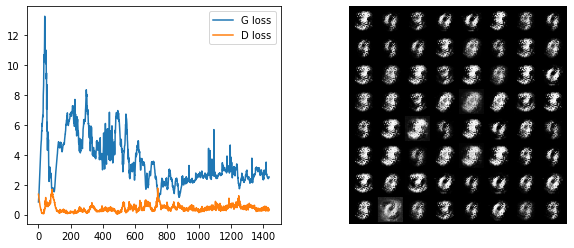

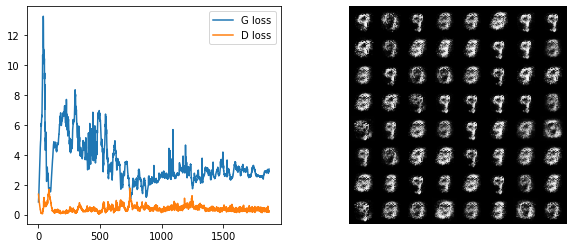

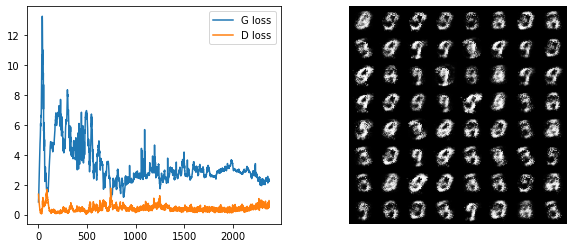

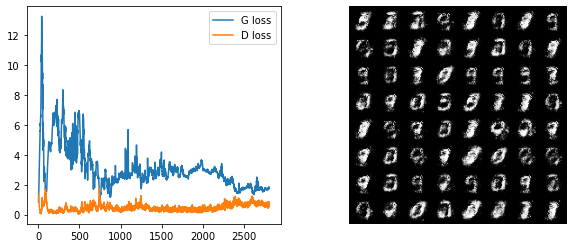

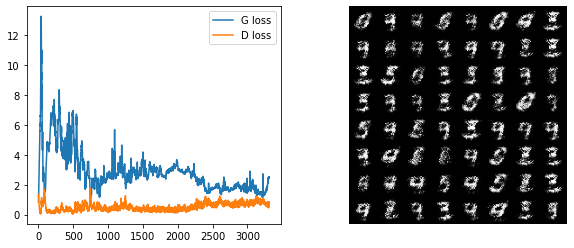

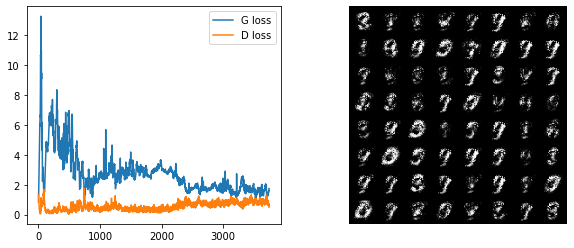

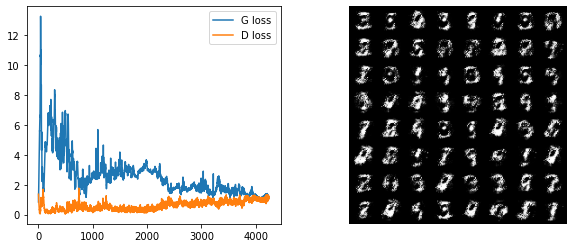

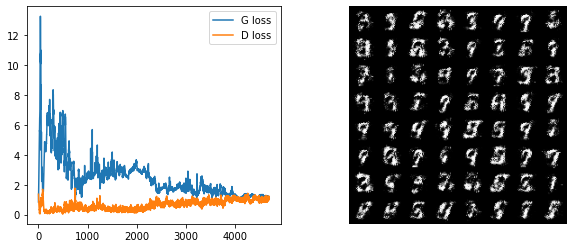

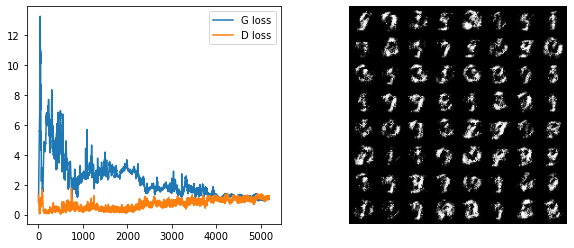

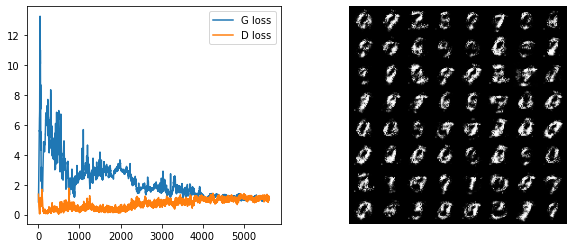

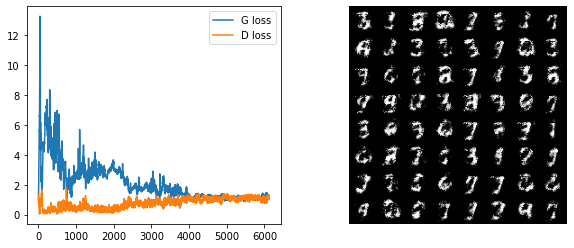

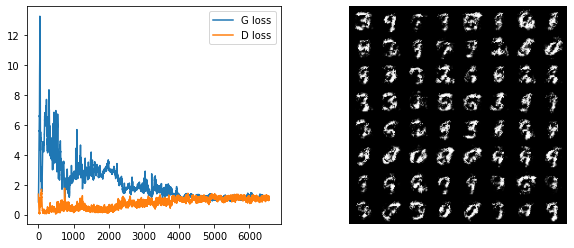

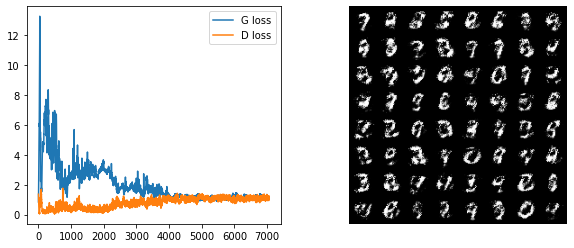

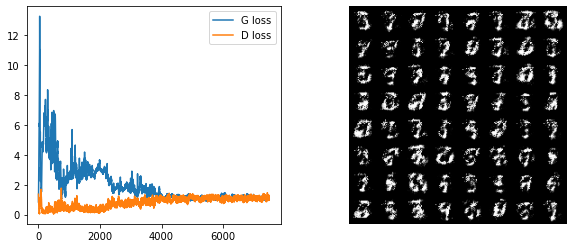

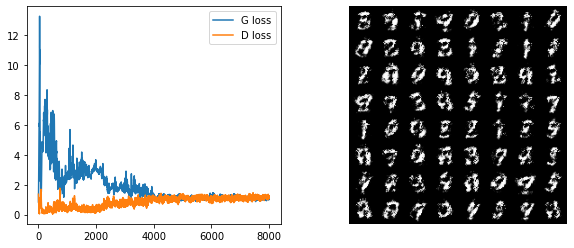

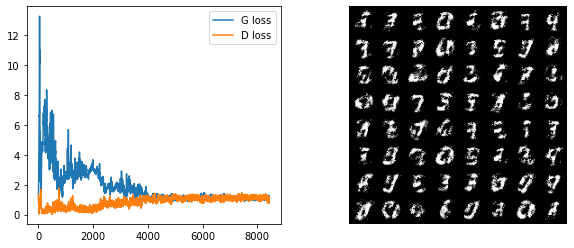

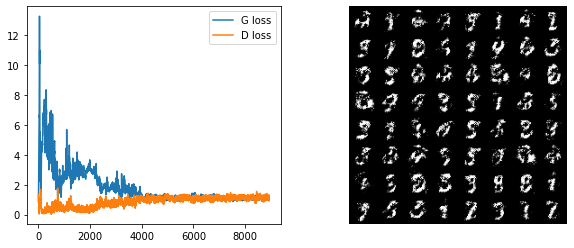

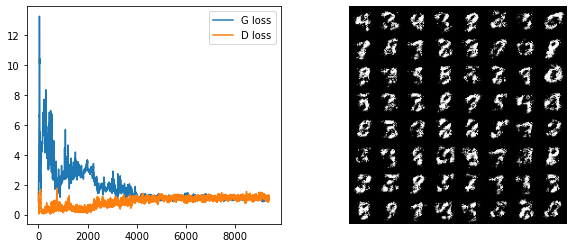

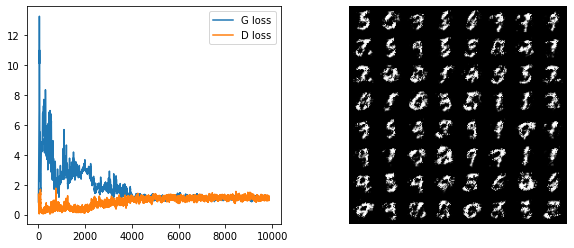

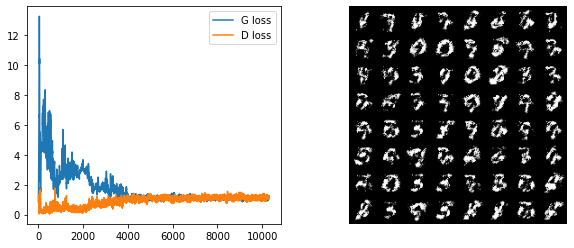

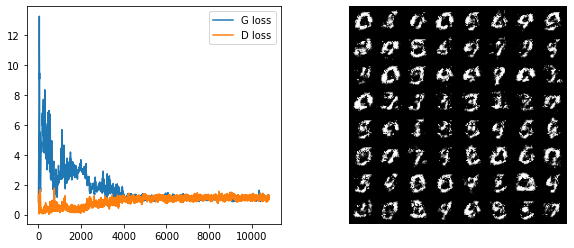

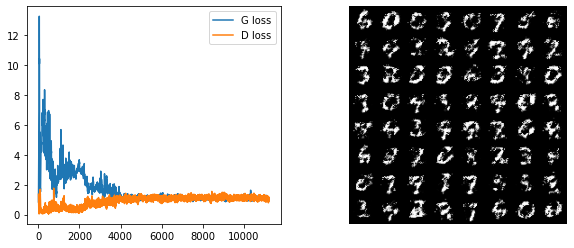

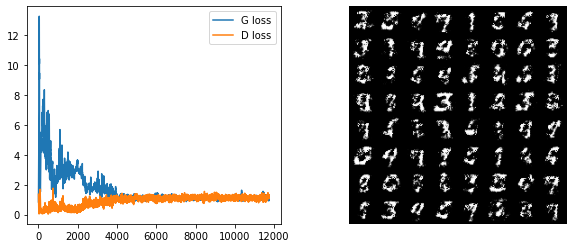

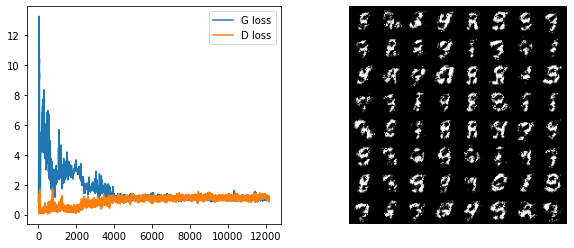

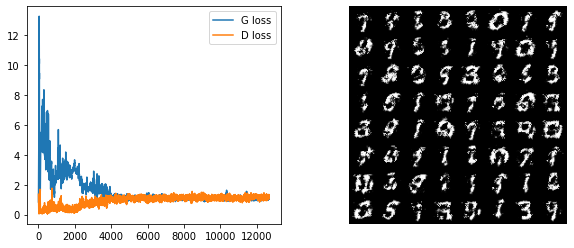

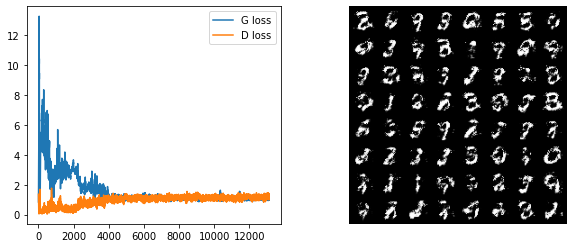

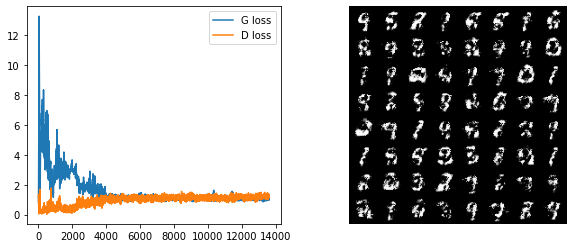

In [10]:
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)
BCE = nn.BCELoss()


G_optim = torch.optim.Adam(G.parameters())
D_optim = torch.optim.Adam(D.parameters())

d_losses = []
g_losses = []
for epoch in range(15):
    for step, (X, _) in enumerate(dataloader):
        X = X.to(DEVICE)
        
        # Train Discriminator
        D_optim.zero_grad()
        D.train()
        G.eval()

        ones = torch.ones((MINIBATCH_SIZE, 1)).to(DEVICE)
        zeros = torch.zeros((MINIBATCH_SIZE, 1)).to(DEVICE)

        z = sample_z(MINIBATCH_SIZE)

        D_loss = BCE(D(X), ones) + BCE(D(G(z)), zeros)
        D_loss.backward()
        D_optim.step()
        d_losses.append(D_loss.item())
    
        # Train Generator
        G_optim.zero_grad()
        G.train()
        D.eval()

        z = sample_z(MINIBATCH_SIZE)
        ones = torch.ones((MINIBATCH_SIZE, 1)).to(DEVICE)

        G_loss = BCE(D(G(z)), ones)
        G_loss.backward()
        G_optim.step()

        g_losses.append(G_loss.item())
        
        if step % 500 == 0:
            # Plot some training results
            G.eval()
            z = sample_z(64)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            axes[0].plot(g_losses, label="G loss")
            axes[0].plot(d_losses, label="D loss")
            axes[0].legend()
            axes[1].imshow(create_image(G(z)))
            axes[1].axis("off")
            plt.show()

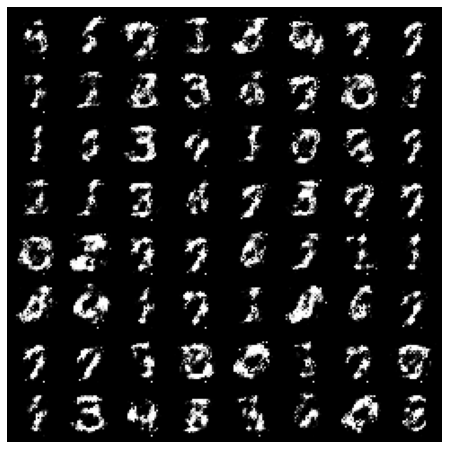

In [13]:
G.eval()

z = sample_z(64)
x = G(z)

fig, ax = plt.subplots(figsize=(8, 8))

plt.imshow(create_image(x))
_ = plt.axis("off")

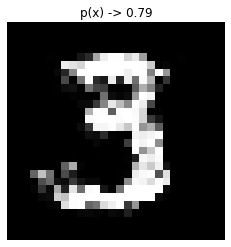

In [14]:
D.eval()

p = D(x)
plt.imshow(create_image(x[p.argmax()]))
plt.title(f"p(x) -> {p.max():.2f}")
_ = plt.axis("off")